# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

Overall Price Summary:
count    976.000000
mean      14.104181
std        0.450276
min       12.837344
25%       13.765795
50%       14.102942
75%       14.384228
max       15.587407
Name: Price_ihs, dtype: float64


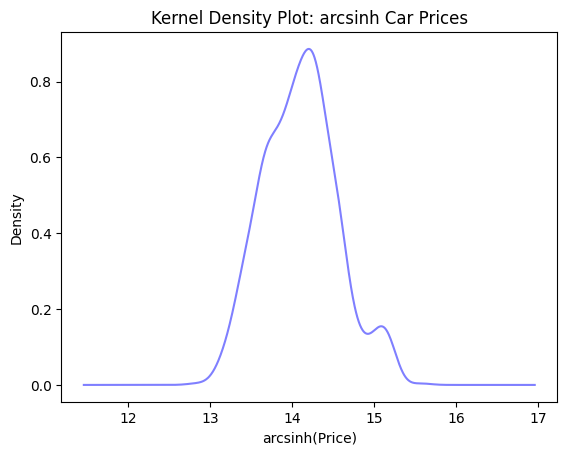

Overall Mileage Summary:
count    976.000000
mean      11.109435
std        0.733389
min        7.711549
25%       10.722241
50%       11.227119
75%       11.651317
max       12.201010
Name: Mileage_Run_ihs, dtype: float64


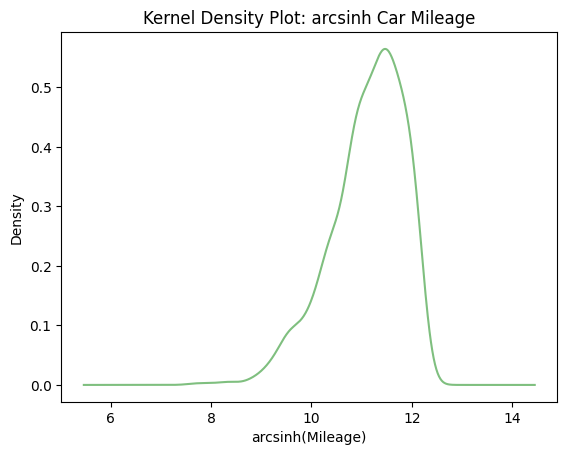

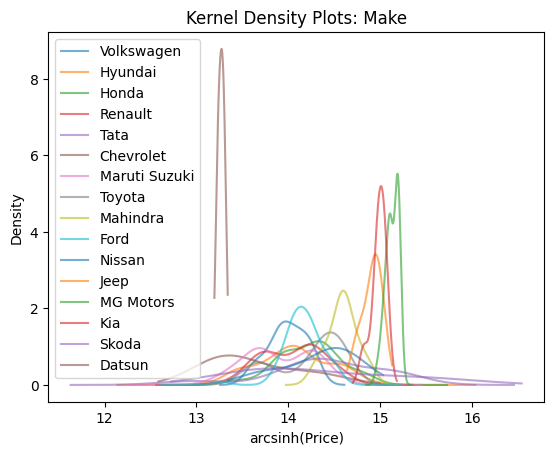

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('cars_hw.csv')

# 1
# Cleaning the data
df['No_of_Owners'] = df['No_of_Owners'].str.replace(r'st|nd|rd|th', '', regex=True).astype(int)
df.drop_duplicates(inplace=True)
df['Price_ihs'] = np.arcsinh(df['Price'])
df['Mileage_Run_ihs'] = np.arcsinh(df['Mileage_Run'])

p_summary = df['Price_ihs'].describe()
print("Overall Price Summary:")
print(p_summary)

# Kernel density plot for Price
plt.figure()
df['Price_ihs'].plot(kind='density', color='blue', alpha=0.5)
plt.title('Kernel Density Plot: arcsinh Car Prices')
plt.xlabel('arcsinh(Price)')
plt.ylabel('Density')
plt.show()

# stats for Mileage (arcsinh-transformed)
m_summary = df['Mileage_Run_ihs'].describe()
print("Overall Mileage Summary:")
print(m_summary)

# Kernel density plot for Mileage
plt.figure()
df['Mileage_Run_ihs'].plot(kind='density', color='green', alpha=0.5)
plt.title('Kernel Density Plot: arcsinh Car Mileage')
plt.xlabel('arcsinh(Mileage)')
plt.ylabel('Density')
plt.show()

# Grouped Kernel Density plot by Make
plt.figure()
for make in df['Make'].unique():
    subset = df[df['Make'] == make]
    subset['Price_ihs'].plot(kind='density', label=make, alpha=0.6)
plt.title('Kernel Density Plots: Make')
plt.xlabel('arcsinh(Price)')
plt.ylabel('Density')
plt.legend()
plt.show()


In [4]:
# 2
from sklearn.model_selection import train_test_split

# Transform categorical variables using one-hot encoding
categorical_vars = ['Color', 'Body_Type', 'Make', 'Fuel_Type', 'Transmission_Type']
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# 3
# train-test split
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=31)

print("Training Set Shape:", train_df.shape)
print("Testing Set Shape:", test_df.shape)

Training Set Shape: (780, 45)
Testing Set Shape: (196, 45)


In [6]:
# 4
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define numeric and target variables
numeric_vars = ['Make_Year', 'Mileage_Run_ihs', 'Seating_Capacity']
categorical_vars = [col for col in train_df.columns if col.startswith('Color_') or
                    col.startswith('Body_Type_') or col.startswith('Make_') or
                    col.startswith('Fuel_Type_') or col.startswith('Transmission_Type_')]

X_train_num = train_df[numeric_vars]
y_train = train_df['Price_ihs']
X_test_num = test_df[numeric_vars]
y_test = test_df['Price_ihs']

# Numeric variables only
model_num = LinearRegression().fit(X_train_num, y_train)
y_train_pred_num = model_num.predict(X_train_num)
y_test_pred_num = model_num.predict(X_test_num)

r2_train_num = r2_score(y_train, y_train_pred_num)
rmse_train_num = np.sqrt(mean_squared_error(y_train, y_train_pred_num))
r2_test_num = r2_score(y_test, y_test_pred_num)
rmse_test_num = np.sqrt(mean_squared_error(y_test, y_test_pred_num))

print("Numeric Model:")
print(f"Train R²: {r2_train_num:.4f}, Train RMSE: {rmse_train_num:.4f}")
print(f"Test R²: {r2_test_num:.4f}, Test RMSE: {rmse_test_num:.4f}")
print()

# Categorical variables only
X_train_cat = train_df[categorical_vars]
X_test_cat = test_df[categorical_vars]

model_cat = LinearRegression().fit(X_train_cat, y_train)
y_train_pred_cat = model_cat.predict(X_train_cat)
y_test_pred_cat = model_cat.predict(X_test_cat)

r2_train_cat = r2_score(y_train, y_train_pred_cat)
rmse_train_cat = np.sqrt(mean_squared_error(y_train, y_train_pred_cat))
r2_test_cat = r2_score(y_test, y_test_pred_cat)
rmse_test_cat = np.sqrt(mean_squared_error(y_test, y_test_pred_cat))

print("Categorical Model:")
print(f"Train R²: {r2_train_cat:.4f}, Train RMSE: {rmse_train_cat:.4f}")
print(f"Test R²: {r2_test_cat:.4f}, Test RMSE: {rmse_test_cat:.4f}")
print("\nCategorical Variables perform better than numeric variables.\n")

# Combined numeric and categorical variables
X_train_all = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_all = pd.concat([X_test_num, X_test_cat], axis=1)

model_all = LinearRegression().fit(X_train_all, y_train)
y_train_pred_all = model_all.predict(X_train_all)
y_test_pred_all = model_all.predict(X_test_all)

r2_train_all = r2_score(y_train, y_train_pred_all)
rmse_train_all = np.sqrt(mean_squared_error(y_train, y_train_pred_all))
r2_test_all = r2_score(y_test, y_test_pred_all)
rmse_test_all = np.sqrt(mean_squared_error(y_test, y_test_pred_all))

print("Combined Model:")
print(f"Train R²: {r2_train_all:.4f}, Train RMSE: {rmse_train_all:.4f}")
print(f"Test R²: {r2_test_all:.4f}, Test RMSE: {rmse_test_all:.4f}")
print("\nThe combined model performs slightly better than categorical.\n")

Numeric Model:
Train R²: 0.4360, Train RMSE: 0.3485
Test R²: 0.3311, Test RMSE: 0.3183

Categorical Model:
Train R²: 0.8252, Train RMSE: 0.1940
Test R²: 0.7346, Test RMSE: 0.2005

Categorical Variables perform better than numeric variables.

Combined Model:
Train R²: 0.8336, Train RMSE: 0.1893
Test R²: 0.7418, Test RMSE: 0.1978

The combined model performs slightly better than categorical.



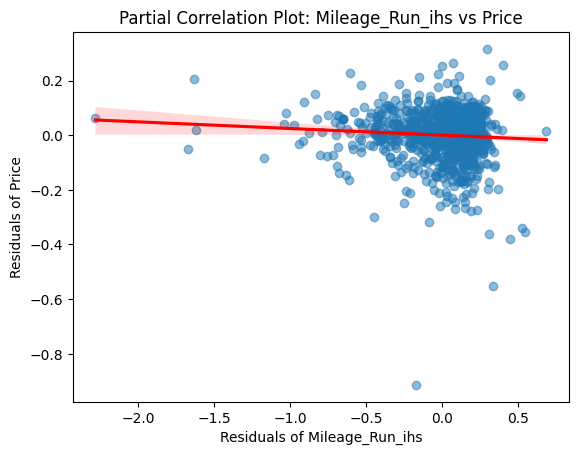

Partial R² for Mileage_Run_ihs: 0.005268


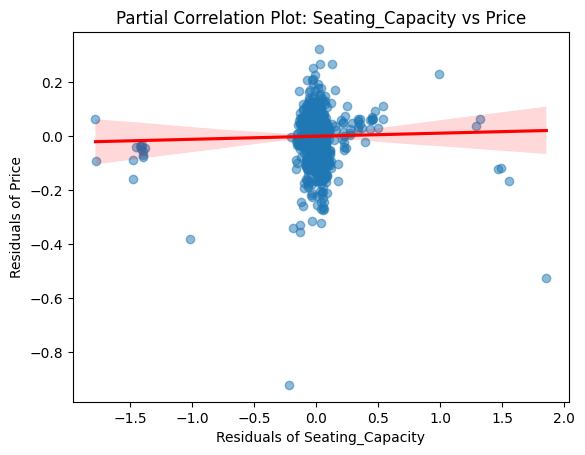

Partial R² for Seating_Capacity: 0.000809


In [12]:
# from number 2
df_encoded = pd.get_dummies(df, drop_first=True)

numeric_vars = ['Mileage_Run_ihs', 'Seating_Capacity']
y = df_encoded['Price_ihs']

for var in numeric_vars:
    x_k = df_encoded[var]
    X_mk = df_encoded.drop(columns=[var, 'Price_ihs'])

    reg_y = LinearRegression(fit_intercept=False).fit(X_mk, y)
    r_y = y - reg_y.predict(X_mk)

    reg_k = LinearRegression(fit_intercept=False).fit(X_mk, x_k)
    r_x = x_k - reg_k.predict(X_mk)

    # Plot partial correlation
    sns.regplot(x=r_x, y=r_y, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.title(f'Partial Correlation Plot: {var} vs Price')
    plt.xlabel(f'Residuals of {var}')
    plt.ylabel('Residuals of Price')
    plt.show()

    # Calculate Partial R²
    reg = LinearRegression().fit(r_x.to_numpy().reshape(-1, 1), r_y.to_numpy())
    partial_r2 = reg.score(r_x.to_numpy().reshape(-1, 1), r_y.to_numpy())
    print(f"Partial R² for {var}: {partial_r2:.6f}")

In [13]:
# 6
current_year = 2025
data = df.copy()
data['Car_Age'] = current_year - data['Make_Year']
data['Car_Age_ihs'] = np.arcsinh(data['Car_Age'])
data['Mileage_Age_Interaction'] = data['Mileage_Run_ihs'] * data['Car_Age_ihs']

# Feature Selection
X_complex = data[['Mileage_Run_ihs', 'Car_Age_ihs', 'Mileage_Age_Interaction']]
y = data['Price_ihs']

# Use existing 80/20 split from previous models
X_train_complex = X_complex.loc[train_df.index]
X_test_complex = X_complex.loc[test_df.index]
y_train_complex = y.loc[train_df.index]
y_test_complex = y.loc[test_df.index]

# Model Training
model_complex = LinearRegression().fit(X_train_complex, y_train_complex)

# Predictions
y_train_pred = model_complex.predict(X_train_complex)
y_test_pred = model_complex.predict(X_test_complex)

# Metrics
complex_metrics = {
    'Train R²': r2_score(y_train_complex, y_train_pred),
    'Train RMSE': np.sqrt(mean_squared_error(y_train_complex, y_train_pred)),
    'Test R²': r2_score(y_test_complex, y_test_pred),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_complex, y_test_pred))
}

print("Complex Model Performance:")
for metric, value in complex_metrics.items():
    print(f"{metric}: {value:.4f}")

Complex Model Performance:
Train R²: 0.4171
Train RMSE: 0.3543
Test R²: 0.2920
Test RMSE: 0.3274


In [ ]:
# 7
# The simpler models, such as the numeric-only model, had lower R² and higher RMSE, indicating underfitting.
# The categorical model performed better by capturing brand and fuel type effects, but the combined model
# (including both numeric and categorical variables) achieved the best balance between bias and variance,
# with a high R² (0.7365) and low RMSE (0.1997).
# The complex model with interaction terms showed improved training performance but poor test performance
# (R² dropped to 0.2920), highlighting overfitting. This demonstrates that model selection should prioritize
# simplicity and generalizability over unnecessary complexity.